# 1 Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# 2 Data preparation

In [2]:
train = pd.read_csv('data/train_after_missing_value_without_dropping_rows.csv')
test = pd.read_csv('data/test_after_missing_value_without_dropping_rows.csv')

#concatinate train and test to later control train-test split
data = pd.concat([train,test])
print("data shape:", data.shape)
print("number of columns with null values:", data.isnull().any().sum())

data shape: (1097231, 289)
number of columns with null values: 44


In [3]:
#drop columns with null values
data = data.dropna(axis=1)
print("new shape of data:", data.shape)

new shape of data: (1097231, 245)


In [4]:
#separate class column from other features
X = data.drop('isFraud', axis = 1)
X = pd.get_dummies(X) #one-hot encoding on categorical features
y = data['isFraud']

# 3 Decision Tree
## 3.1 Decision Tree with unbalanced data

In [5]:
#split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(768061, 244)
(329170, 244)
(768061,)
(329170,)


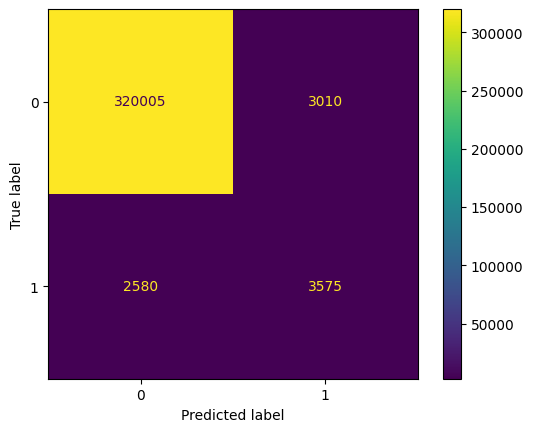

In [6]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
CM = ConfusionMatrixDisplay(cm)
CM.plot()

Here we calculate the false positive rate and the false negative rate. The first says how likey a transaction will be predicted to be fraud, when in truth the transaction is not fraud. The second says how likey a transaction will be predicted to not be fraud, when in truth the transaction is fraud. It is important to keep false negative rate low. 

In [7]:
fp = cm[0][1]
tn = cm[0][0]
fpr = fp/(fp+tn)
print('false positive rate =', round(fpr, 4))

fn = cm[1][0]
tp = cm[1][1]
fnr = fn/(fn+tp)
print('false negative rate =', round(fnr, 4))

false positive rate = 0.0093
false negative rate = 0.4192


In [8]:
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('accuracy =', round(acc, 4))
print('recall =',round(rec, 4))
print('precision =', round(prec, 4))
print('f1 score =', round(f1, 4))

accuracy = 0.983
recall = 0.5808
precision = 0.5429
f1 score = 0.5612


This model meets the success criteria of an accuracy rate of at least 80% and false positive rate of at most 5%. But because the data that was used to train this model is so unbalanced, we look to the f1 score. But this score is less than 80%. This means this model fails the success criteria.

It is also important to note that the while the false positive rate is 0.9%, the false negative rate is about 42%. 

## 3.2 Decision Tree with Under-Samping

To manage the unbalanced data, we will use the under-sampling technique to balance the data. Under-sampling randomly takes data points from the majority class to match the number of data points in the minority class. Under-sampling can get rid of important data points, but it may also improve the false negative rate and the f1 score. 

In [9]:
#split data by class
class0 = data[data['isFraud'] == 0]
class1 = data[data['isFraud'] == 1]
print('class 0:', class0.shape)
print('class 1:', class1.shape)

class 0: (1076568, 245)
class 1: (20663, 245)


In [10]:
#under-sample the majority class so it is balanced with the minority class
under_class0 = resample(class0, replace=False, n_samples=class1.shape[0], random_state=42)
print('new class 0:', under_class0.shape)
print('new class 1:', class1.shape)
under_data = pd.concat([under_class0, class1])

new class 0: (20663, 245)
new class 1: (20663, 245)


In [11]:
X = under_data.drop('isFraud', axis = 1)
X = pd.get_dummies(X)
y = under_data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33060, 244)
(8266, 244)
(33060,)
(8266,)


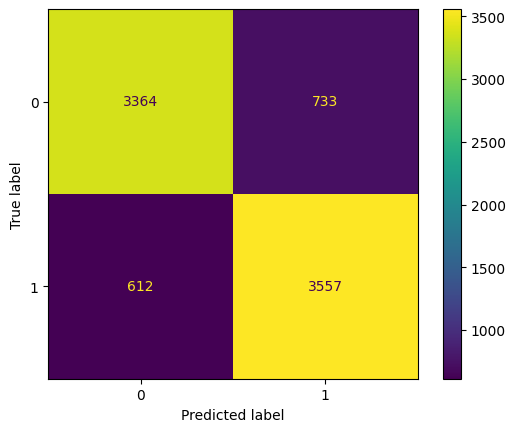

In [12]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
CM = ConfusionMatrixDisplay(cm)
CM.plot()

In [13]:
fp = cm[0][1]
tn = cm[0][0]
fpr = fp/(fp+tn)
print('false positive rate =', round(fpr, 4))

fn = cm[1][0]
tp = cm[1][1]
fnr = fn/(fn+tp)
print('false negative rate =', round(fnr, 4))

false positive rate = 0.1789
false negative rate = 0.1468


In [14]:
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('accuracy =', round(acc, 4))
print('recall =',round(rec, 4))
print('precision =', round(prec, 4))
print('f1 score =', round(f1, 4))

accuracy = 0.8373
recall = 0.8532
precision = 0.8291
f1 score = 0.841


By using under-sampling we reduced the accuracy from 98% to 84%, but the accuracy still meets the success criteria. The false potivite rate also increased from 0.9% to 18%, so it doesn't meet our success criteria anymore.

By under-sampling we were able to decrease the false negative rate from 42% to 15%. The f1 score also increased from 56% to 84%.

This model's metric results are an overall significant improvement over the previous model's metric results.

## 3.3 Decision Tree with Stratified Cross-Validation and Under-Sampling

In [15]:
acc_list = []
f1_list = []
fpr_list = []
fnr_list = []
folds = 5
i = 1

for train, test in StratifiedKFold(n_splits=folds,random_state=1, shuffle=True).split(X, y):
    print(i)
    i+=1
    
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = y.iloc[train], y.iloc[test]
    tree = DecisionTreeClassifier(criterion='entropy')
    tree.fit(x_train_one_fold, y_train_one_fold)
    
    y_pred = tree.predict(x_test_one_fold)
    cm = confusion_matrix(y_test_one_fold, y_pred)
    fp = cm[0][1]
    tn = cm[0][0]
    fn = cm[1][0]
    tp = cm[1][1]
    fpr = fp/(fp+tn)
    fnr = fn/(fn+tp)
    
    acc_list.append(accuracy_score(y_test_one_fold, y_pred))
    f1_list.append(f1_score(y_test_one_fold, y_pred, pos_label=1))
    fpr_list.append(fpr)
    fnr_list.append(fnr)

1
2
3
4
5


In [16]:
import statistics as stat

acc_mean = stat.mean(acc_list)
acc_std = stat.stdev(acc_list)

f1_mean = stat.mean(f1_list)
f1_std = stat.stdev(f1_list)

fpr_mean = stat.mean(fpr_list)
fpr_std = stat.stdev(fpr_list)

fnr_mean = stat.mean(fnr_list)
fnr_std = stat.stdev(fnr_list)

print("acc = %.4f (%.4f)" % (acc_mean, acc_std))
print("f1  = %.4f (%.4f)" % (f1_mean, f1_std))
print("fpr = %.4f (%.4f)" % (fpr_mean, fpr_std))
print("fnr = %.4f (%.4f)" % (fnr_mean, fnr_std))

acc = 0.8406 (0.0046)
f1  = 0.8417 (0.0054)
fpr = 0.1666 (0.0035)
fnr = 0.1522 (0.0099)


Since the standard deviation for all the metrics of all the folds are all relatively low, the metrics for each fold are close to the mean metrics. 